This code was based on in the following references:

[1] "Particle Swarm Optimization" published in 1995 by James Kennedy and Russell Eberhart

[2] "A New Optimizer Using Particle Swarm Theory" published in 1995 by James Kennedy and Russell Eberhart

[3] "A Novel Search Algorithm based on Fish School Behavior" published in 2008 by Bastos Filho, Lima Neto, Lins, D. O. Nascimento and P. Lima

[4] "An Enhanced Fish School Search Algorithm" published in 2013 by Bastos Filho and  D. O. Nascimento

[5] "Defining a Standard for Particle Swarm Optimization" published in 2007 by Bratton and Kennedy

signal ranked wilcoxon non-parametrical test

https://ieeexplore.ieee.org/document/8790158

https://arxiv.org/abs/2201.00523

https://titan.csit.rmit.edu.au/~e46507/cec13-niching/competition/cec2013-niching-benchmark-tech-report.pdf

### Imports

In [1]:
import os
import sys
import csv
import random
import copy
import math
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as sts
from random import randint
from IPython.display import display, HTML
from google.colab import drive, files
%matplotlib inline
plt.rcParams["figure.figsize"] = (18,9)

### Connection with Google Drive

In [2]:
drive.mount('/content/drive', force_remount=True) #  Connect to drive
FOLDERNAME = 'POLI/decimo/tcc/Algoritms/Results/' #  Set folder that have the datasts
assert FOLDERNAME is not None, "[!] Enter the foldername."
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME)) #  Locale the foldeer

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/POLI/decimo/tcc/Algoritms/Results


### Validation 30 bests execution of each algoritms

Get files CVSs that contains informations about many executions that have the bests values found by each algoritm. The algoritms are PSO, GWO and FSS and they has 30 execution with 1K iterations for the same objective functions with the same dimention.

In [3]:
optimizers = ["PSO", "FSS", "GWO", "VGWO"]
files_30 = []
files_15 = []
filepath = os.path.dirname(os.path.abspath('Results'))
for opt in optimizers:
  filename = f"{filepath}/30d/{opt}_exec.csv"
  df = pd.read_csv(filename)
  files_30.append(df)
  filename = f"{filepath}/15d/{opt}_exec.csv"
  df = pd.read_csv(filename)
  files_15.append(df)

results_15 = pd.concat(files_15)
results_15.sort_values(by=['func'], ascending=False)
results_30 = pd.concat(files_30)
results_30.sort_values(by=['func'], ascending=False)
results = {15: results_15, 30: results_30}
results[30].head(5)

,opt,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run21,run22,run23,run24,run25,run26,run27,run28,run29,run30
0,PSO,Sphere,80.908248,5.783498e+01,1.644284e+03,2.782463e+03,1.000001e+04,2.276045e+02,1.000916e+04,354.887017,...,2.726546e+02,4.958197e+01,2.283801e+02,1.212653e+04,2.478368e+02,2.916612e+02,1.017897e+01,1.001052e+04,1.782025e+02,5.537987e+01
1,PSO,RotatedHyperEllipsoid,247.963528,3.964699e+04,1.933843e+04,1.895164e+04,2.151304e+04,1.123215e+04,9.152254e+02,28510.466930,...,1.292174e+04,3.615022e+04,6.374419e+02,1.961752e+04,5.330353e+03,6.292114e+04,4.342245e+03,1.170692e+04,4.134684e+03,4.646906e+03
2,PSO,Rosenbrock,89.222076,1.644162e+05,1.444136e+03,3.103990e+03,3.190455e+03,2.552638e+05,2.941244e+03,212.169457,...,9.040890e+04,2.338033e+04,3.960127e+04,1.316911e+03,3.919706e+02,3.394787e+06,1.089811e+02,2.788497e+05,1.871980e+02,4.364654e+04
3,PSO,Dixon-Price,114.810678,8.135499e+01,6.892666e-04,5.815266e+05,2.501212e+05,8.100000e+01,2.501480e+01,81.001815,...,4.000768e+00,6.090931e+02,8.100000e+01,7.357512e+05,6.369867e-03,9.012100e+04,8.874589e+05,1.726955e-02,2.594007e+05,8.122569e+01
4,PSO,Perm,1274.395211,1.366811e+10,4.148606e+06,4.680964e+13,1.506540e+19,1.215291e+19,1.332117e+11,1699.360675,...,4.191693e+16,1.640635e+11,2.489181e+15,6.915164e+17,1.546985e+07,9.343511e+21,4.166491e+22,7.696782e+27,9.715829e+13,7.834903e+09


We separete in each objective functions and comparete each algoritm to show the best score found in each execution. Unfortunately the PSO shows in many execution a big score, it became the GWO and FSS visualization difficult.

Functions w/ 15 dim


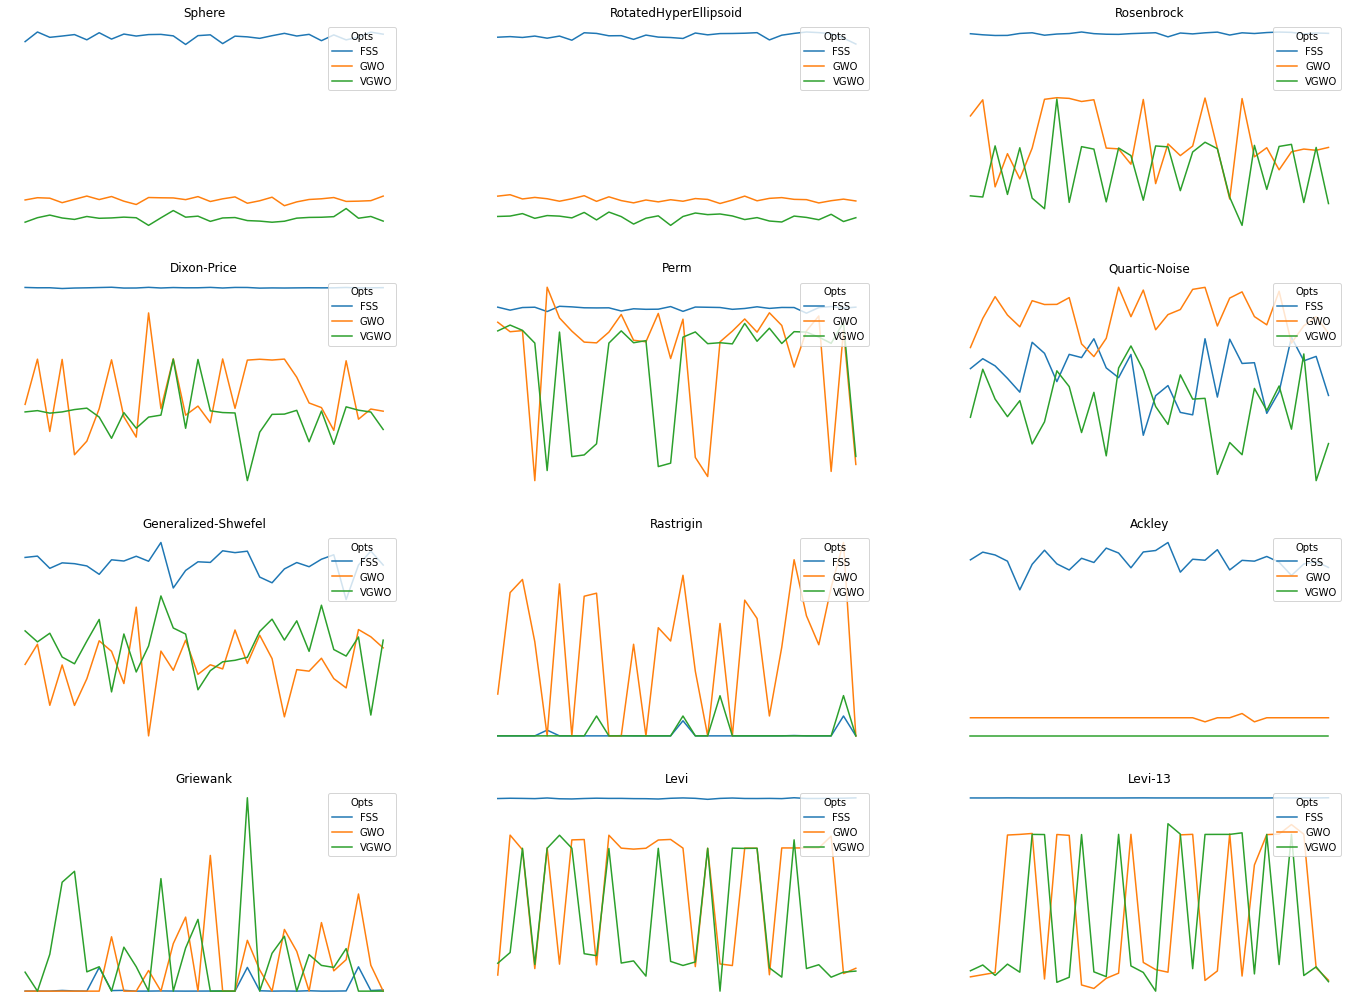

Functions w/ 30 dim


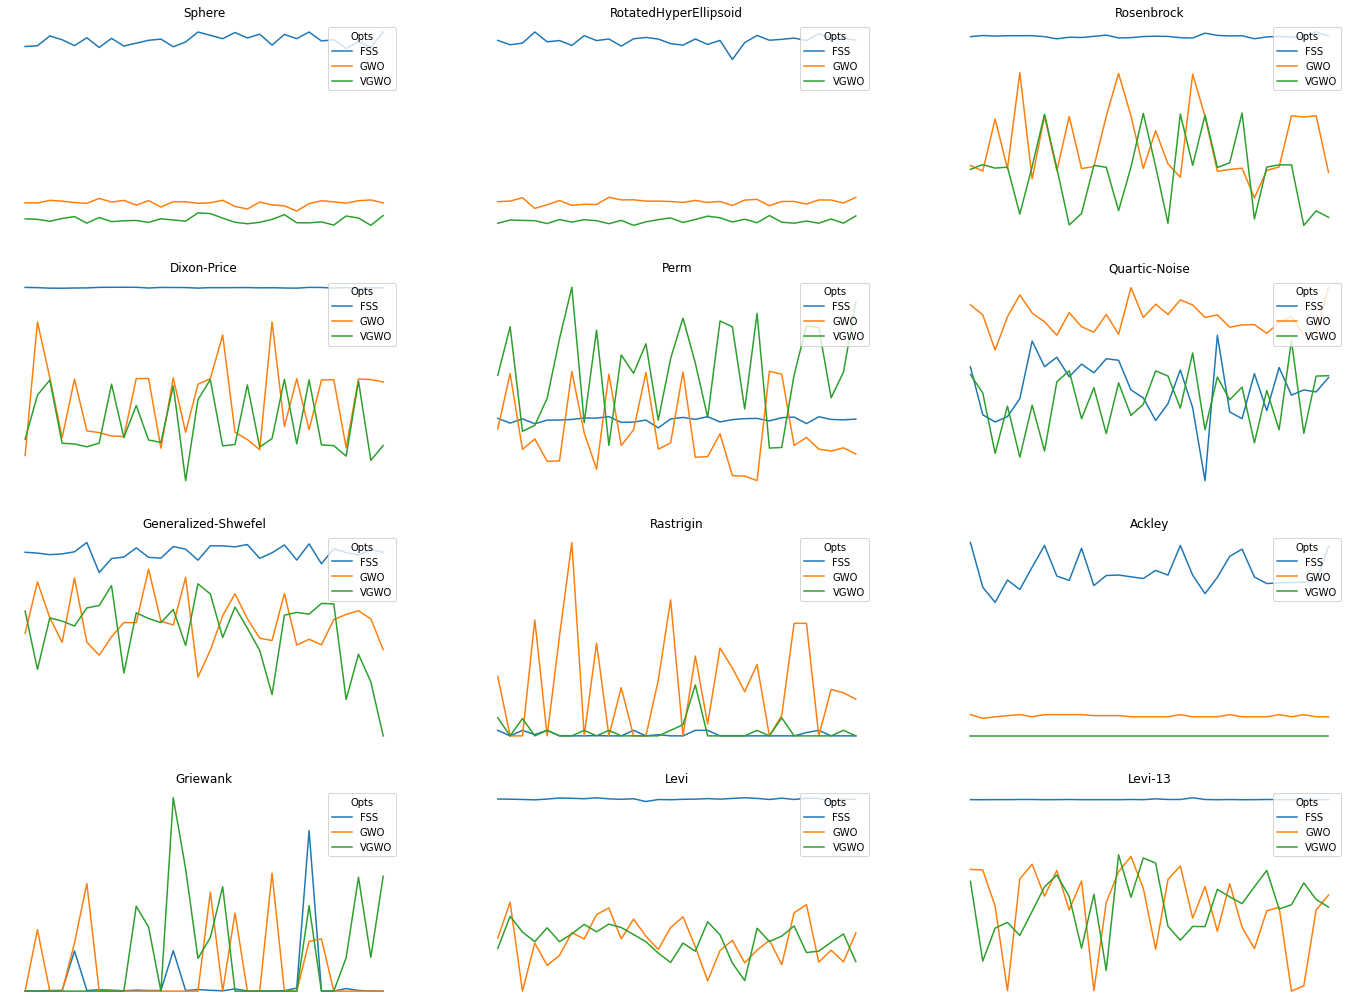

In [4]:
plt.rcParams["figure.figsize"] = (24,18)
tb_dt = {}
for d in results:
  tb_dt[d] = {}
  objective_functions = results[d]['func'].unique()
  opts = results[d]['opt'].unique()
  print(f"Functions w/ {d} dim")
  for i, func in enumerate(objective_functions):
    tb_dt[d][func] = {}
    plt.subplot(4, 3, i+1)
    plt.axis('off')
    for o in opts[1:]:
      res = results[d][results[d]['func'] == func]
      res = res[res['opt'] == o].head(1)
      res = res.drop(['opt', 'func', 'exec_time'], axis=1)
      y = res.values.tolist()[0]
      tb_dt[d][func][o] = y
      dt = pd.DataFrame(data=y, index=range(1, len(y)+1), columns=['score'])
      plt.plot(dt, label=o)
      if func not in ['Rastrigin', 'Griewank', 'Vicent']:
        plt.yscale('log')
      plt.legend(loc='upper right', title='Opts')
    plt.title(func)
  plt.show()

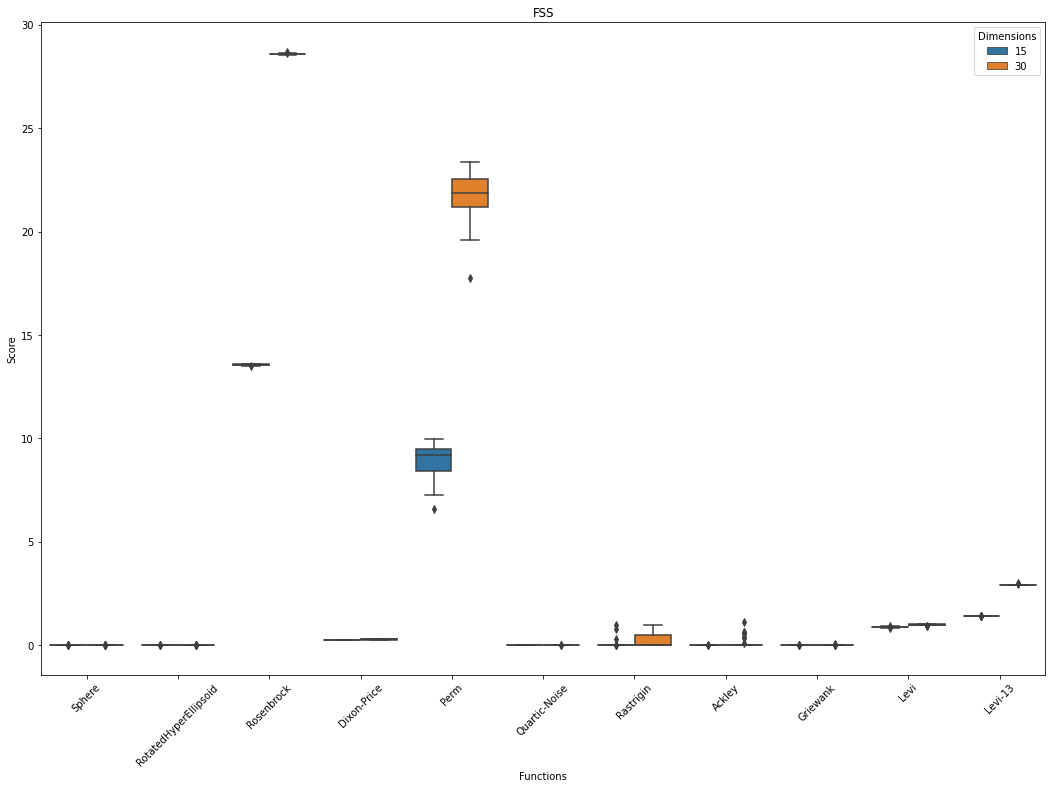

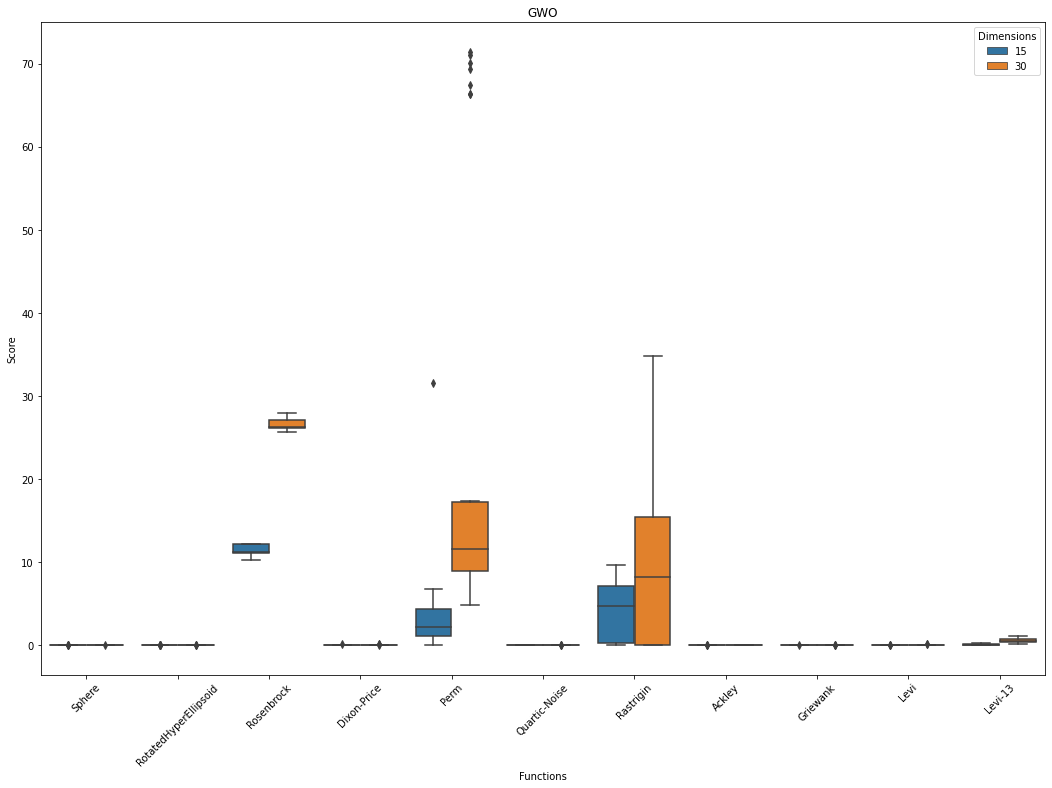

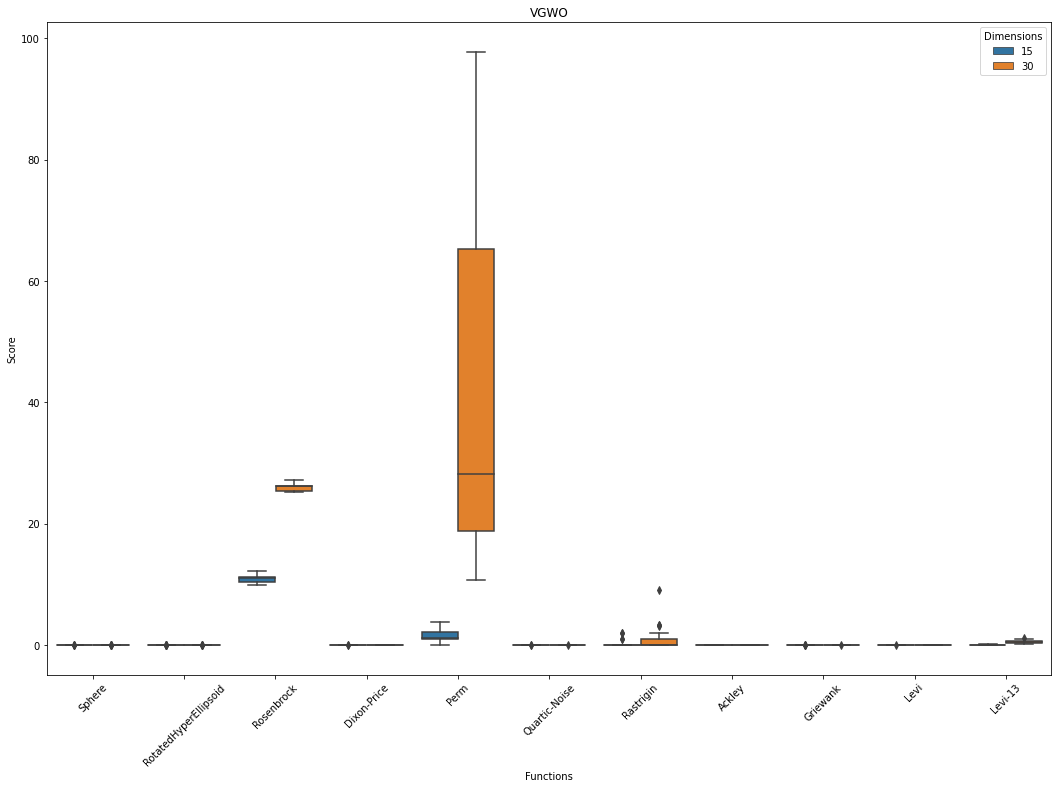

In [5]:
plt.rcParams["figure.figsize"] = (18,12)
for opt in opts[1:]:
  obj_show = []
  for d in results:
    objective_functions = results[d]['func'].unique()
    for func in objective_functions:
      res = results[d][results[d]['func'] == func]
      res = res[res['opt'] == opt].head(1)
      res = res.drop(['opt', 'func', 'exec_time'], axis=1)
      scores = res.values.tolist()[0]
      for s in scores:
        obj_show.append({'func': func, 'score': s, 'dim': d})

  res = pd.DataFrame(data=obj_show, index=range(len(obj_show)), columns=['func', 'score', 'dim'])
  res = res[res["score"] <= 100] # remove outliers
  ax = sns.boxplot(data=res, x='func', y='score', hue="dim")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set(xlabel='Functions', ylabel='Score', title=f"{opt}")
  plt.legend(loc='upper right', title='Dimensions')
  # plt.yscale('log')
  plt.show()

In [6]:
dt_func = []
for d in tb_dt:
  for func in tb_dt[d]:
    print(f"{func} w/ {d} dim")
    opts = list(tb_dt[d][func].keys())
    size_tb = len(tb_dt[d][func]["VGWO"])
    lines = [[tb_dt[d][func][o][i] for o in opts] for i in range(size_tb)]
    dt = pd.DataFrame(data=lines, index=range(1, len(tb_dt[d][func][o])+1), columns=opts)
    dt_func.append(dt)

    wil_fss_vgwo = sts.wilcoxon(dt['FSS'].tolist(), dt['VGWO'].tolist())
    wil_gwo_vgwo = sts.wilcoxon(dt['GWO'].tolist(), dt['VGWO'].tolist())
    print('FSS-VGWO', wil_fss_vgwo)
    print('GWO-VGWO', wil_gwo_vgwo)
    print(dt.describe())
    print()

    # display(dt)
    display(dt.loc[:].style.highlight_min(axis=1, props='color:white; font-weight:bold; background-color:green;'))
# dt_func[1].loc[:5].style.highlight_min(axis=1, props='color:white; font-weight:bold; background-color:green;')

Sphere w/ 15 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
                FSS            GWO           VGWO
count  3.000000e+01   3.000000e+01   3.000000e+01
mean   1.028825e-08   6.466608e-99  2.120542e-106
std    2.605870e-08   1.174309e-98  1.077564e-105
min    1.476432e-14  2.141822e-103  3.136044e-114
25%    5.668167e-11  6.544889e-101  2.495093e-111
50%    7.286150e-10  6.340672e-100  4.216453e-110
75%    4.975500e-09   6.410058e-99  1.069117e-109
max    1.091895e-07   4.383018e-98  5.900195e-105



,FSS,GWO,VGWO
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000


RotatedHyperEllipsoid w/ 15 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
                FSS            GWO           VGWO
count  3.000000e+01   3.000000e+01   3.000000e+01
mean   1.199343e-09  7.552431e-103  1.224541e-112
std    2.220125e-09  2.434415e-102  3.475861e-112
min    1.416956e-15  1.278899e-106  4.169765e-119
25%    7.403946e-12  3.759772e-105  1.727884e-115
50%    7.734862e-11  2.365747e-104  4.553857e-114
75%    1.587305e-09  1.028047e-103  1.511300e-113
max    1.049983e-08  1.292023e-101  1.624458e-111



,FSS,GWO,VGWO
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000


Rosenbrock w/ 15 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=91.0, pvalue=0.003609433349384215)
             FSS        GWO       VGWO
count  30.000000  30.000000  30.000000
mean   13.560743  11.387168  10.813893
std     0.025826   0.585521   0.547837
min    13.488928  10.302718   9.861661
25%    13.548854  11.082559  10.321418
50%    13.563401  11.212488  11.106731
75%    13.579734  12.140447  11.238424
max    13.598233  12.191697  12.164539



,FSS,GWO,VGWO
1,13.559119,11.828291,10.357224
2,13.534945,12.148879,10.337512
3,13.519506,10.513046,11.254004
4,13.521259,11.108949,10.381544
5,13.565324,10.653492,11.218522
6,13.580363,11.212105,10.317711
7,13.525605,12.159458,10.138217
8,13.552050,12.191697,12.164539
9,13.562952,12.178000,10.245316
10,13.598233,12.115152,11.239485


Dixon-Price w/ 15 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=95.0, pvalue=0.004681835234144671)
             FSS        GWO       VGWO
count  30.000000  30.000000  30.000000
mean    0.245436   0.006748   0.001437
std     0.003024   0.014594   0.002423
min     0.237497   0.000149   0.000047
25%     0.243197   0.000816   0.000561
50%     0.245008   0.001249   0.000958
75%     0.248126   0.010025   0.001053
max     0.251217   0.080423   0.010339



,FSS,GWO,VGWO
1,0.248917,0.001392,0.000997
2,0.245273,0.010341,0.001056
3,0.245664,0.000418,0.000945
4,0.237497,0.010227,0.000997
5,0.242580,0.000149,0.001107
6,0.244849,0.000273,0.001179
7,0.248151,0.001150,0.000793
8,0.251217,0.010050,0.000309
9,0.242310,0.000800,0.000965
10,0.242977,0.000326,0.000484


Perm w/ 15 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=113.0, pvalue=0.013974564120258317)
             FSS        GWO       VGWO
count  30.000000  30.000000  30.000000
mean    8.890556   3.394441   1.424648
std     0.847217   5.698581   1.087423
min     6.601332   0.000269   0.000494
25%     8.435531   1.111095   1.036864
50%     9.170110   2.190931   1.158656
75%     9.464467   4.394371   2.149535
max     9.990510  31.522624   3.786548



,FSS,GWO,VGWO
1,9.471295,3.815611,2.261419
2,7.904575,2.151450,3.214521
3,9.265910,2.299934,2.336677
4,9.443981,0.000269,1.085377
5,7.270124,31.522624,0.000494
6,9.990510,4.943030,2.108209
7,9.640211,2.232457,0.001147
8,9.118256,1.149972,0.001268
9,9.051279,1.098136,0.002481
10,9.102800,2.101488,1.083182


Quartic-Noise w/ 15 dim
FSS-VGWO WilcoxonResult(statistic=76.0, pvalue=0.0012866311206026155)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
             FSS        GWO       VGWO
count  30.000000  30.000000  30.000000
mean    0.000113   0.000610   0.000048
std     0.000075   0.000333   0.000047
min     0.000013   0.000144   0.000003
25%     0.000049   0.000361   0.000015
50%     0.000105   0.000502   0.000034
75%     0.000152   0.000873   0.000058
max     0.000261   0.001203   0.000200



,FSS,GWO,VGWO
1,0.000100,0.000190,0.000023
2,0.000135,0.000464,0.000098
3,0.000109,0.000903,0.000039
4,0.000074,0.000514,0.000023
5,0.000049,0.000359,0.000038
6,0.000224,0.000798,0.000010
7,0.000159,0.000710,0.000020
8,0.000067,0.000713,0.000093
9,0.000155,0.000876,0.000058
10,0.000140,0.000213,0.000014


Generalized-Shwefel w/ 15 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=113.0, pvalue=0.013974564120258317)
               FSS          GWO         VGWO
count    30.000000    30.000000    30.000000
mean   4582.352599  2472.034391  2760.811256
std     323.885802   414.374963   425.057256
min    3659.141555  1559.757427  1776.698712
25%    4459.451570  2246.598085  2514.290556
50%    4614.101270  2436.022841  2814.705137
75%    4788.359026  2750.882553  2989.060130
max    5228.087565  3489.432882  3742.672325



,FSS,GWO,VGWO
1,4761.795989,2438.756030,3007.807848
2,4801.705304,2766.235016,2807.877689
3,4448.207517,1888.434227,2963.973589
4,4603.090030,2430.308438,2554.172865
5,4579.523644,1886.920445,2448.356910
6,4514.840405,2229.596874,2821.532586
7,4284.840949,2827.346592,3231.138036
8,4691.515214,2646.858111,2053.496462
9,4656.342938,2163.808102,2950.101433
10,4797.213371,3489.432882,2325.935559


Rastrigin w/ 15 dim
FSS-VGWO WilcoxonResult(statistic=113.0, pvalue=0.013974564120258317)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=2.7015948487105512e-05)
                FSS        GWO       VGWO
count  3.000000e+01  30.000000  30.000000
mean   6.889515e-02   4.327385   0.200543
std    2.276291e-01   3.217355   0.553304
min    1.470255e-10   0.000000   0.000000
25%    1.361239e-07   0.249079   0.000000
50%    4.535413e-06   4.728947   0.000000
75%    6.246037e-05   7.104578   0.000000
max    9.949591e-01   9.680935   2.016439



,FSS,GWO,VGWO
1,0.000053,2.093454,0.000000
2,0.000000,7.173910,0.000000
3,0.000005,7.830409,0.000000
4,0.000000,4.708266,0.000000
5,0.287868,0.000000,0.000000
6,0.000000,7.609664,0.000000
7,0.000000,0.000000,0.000000
8,0.000006,6.991023,0.000000
9,0.000001,7.142429,0.995102
10,0.000000,0.000000,0.000000


Ackley w/ 15 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.444254919152208e-07)
             FSS           GWO          VGWO
count  30.000000  3.000000e+01  3.000000e+01
mean    0.000801  7.549517e-15  4.440892e-16
std     0.001184  1.615983e-15  0.000000e+00
min     0.000004  3.996803e-15  4.440892e-16
25%     0.000201  7.549517e-15  4.440892e-16
50%     0.000346  7.549517e-15  4.440892e-16
75%     0.001082  7.549517e-15  4.440892e-16
max     0.006005  1.465494e-14  4.440892e-16



,FSS,GWO,VGWO
1,0.000398,0.000000,0.000000
2,0.001330,0.000000,0.000000
3,0.000854,0.000000,0.000000
4,0.000323,0.000000,0.000000
5,0.000004,0.000000,0.000000
6,0.000199,0.000000,0.000000
7,0.001794,0.000000,0.000000
8,0.000213,0.000000,0.000000
9,0.000082,0.000000,0.000000
10,0.000509,0.000000,0.000000


Griewank w/ 15 dim
FSS-VGWO WilcoxonResult(statistic=83.0, pvalue=0.002105260340900366)
GWO-VGWO WilcoxonResult(statistic=150.0, pvalue=0.517212372332283)
             FSS        GWO       VGWO
count  30.000000  30.000000  30.000000
mean    0.001080   0.010422   0.014450
std     0.003017   0.014596   0.019198
min     0.000001   0.000000   0.000000
25%     0.000019   0.000000   0.000000
50%     0.000050   0.000000   0.010032
75%     0.000213   0.019025   0.017941
max     0.010141   0.056644   0.080718



,FSS,GWO,VGWO
1,0.000029,0.000000,0.007915
2,0.000038,0.000000,0.000000
3,0.000009,0.000000,0.015387
4,0.000284,0.000000,0.045452
5,0.000066,0.000000,0.050011
6,0.000019,0.000000,0.008046
7,0.009876,0.000000,0.010168
8,0.000230,0.022689,0.000000
9,0.000316,0.000000,0.018346
10,0.000002,0.000000,0.010191


Levi w/ 15 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=111.0, pvalue=0.012452560438554458)
             FSS           GWO          VGWO
count  30.000000  3.000000e+01  3.000000e+01
mean    0.885540  1.312807e-02  6.119140e-03
std     0.025282  1.238466e-02  9.602293e-03
min     0.819602  2.895778e-07  7.430090e-08
25%     0.872121  6.947133e-07  5.625255e-07
50%     0.886782  1.316829e-02  9.362581e-07
75%     0.897527  1.353697e-02  1.306586e-02
max     0.936736  3.973864e-02  3.939944e-02



,FSS,GWO,VGWO
1,0.877025,0.000000,0.000001
2,0.897841,0.039739,0.000002
3,0.886521,0.011566,0.013076
4,0.870305,0.000000,0.000001
5,0.919422,0.013555,0.013074
6,0.859489,0.000001,0.039399
7,0.846828,0.026571,0.013145
8,0.879606,0.027444,0.000002
9,0.902763,0.000001,0.000001
10,0.887606,0.039427,0.012831


Levi-13 w/ 15 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=203.0, pvalue=0.5440062075841892)
             FSS        GWO       VGWO
count  30.000000  30.000000  30.000000
mean    1.392010   0.047083   0.044252
std     0.005004   0.057154   0.058815
min     1.386192   0.000001   0.000001
25%     1.389327   0.000004   0.000004
50%     1.390313   0.000008   0.000008
75%     1.391882   0.099817   0.099965
max     1.410987   0.203355   0.215841



,FSS,GWO,VGWO
1,1.391213,0.000003,0.000005
2,1.389068,0.000004,0.000008
3,1.389445,0.000005,0.000004
4,1.398555,0.095506,0.000009
5,1.391403,0.100033,0.000005
6,1.386192,0.106940,0.100009
7,1.389903,0.000003,0.098929
8,1.388577,0.099169,0.000002
9,1.389707,0.093286,0.000003
10,1.389599,0.000002,0.098972


Sphere w/ 30 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
                FSS           GWO          VGWO
count  3.000000e+01  3.000000e+01  3.000000e+01
mean   2.628171e-06  2.668564e-64  1.750635e-69
std    6.041000e-06  4.851796e-64  5.062388e-69
min    3.480964e-11  1.058835e-67  1.097678e-72
25%    4.053768e-10  4.243901e-65  1.259859e-71
50%    3.886456e-08  8.518907e-65  6.775217e-71
75%    6.760926e-07  3.642721e-64  3.878425e-70
max    1.938004e-05  2.576325e-63  2.461955e-68



,FSS,GWO,VGWO
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000001,0.000000,0.000000
4,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000


RotatedHyperEllipsoid w/ 30 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
                FSS           GWO          VGWO
count  3.000000e+01  3.000000e+01  3.000000e+01
mean   8.026679e-09  1.043488e-64  4.873640e-71
std    3.052544e-08  2.044012e-64  1.119998e-70
min    7.179684e-17  1.224343e-67  2.078945e-73
25%    2.946856e-11  4.911382e-66  1.718582e-72
50%    2.417110e-10  2.931687e-65  8.251967e-72
75%    9.022526e-10  8.914843e-65  2.122991e-71
max    1.628678e-07  7.550685e-64  4.712206e-70



,FSS,GWO,VGWO
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000


Rosenbrock w/ 30 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=136.0, pvalue=0.04716174720825457)
             FSS        GWO       VGWO
count  30.000000  30.000000  30.000000
mean   28.592750  26.631600  26.120656
std     0.026848   0.624971   0.614960
min    28.546286  25.687410  25.222655
25%    28.576783  26.163780  25.467746
50%    28.592487  26.235897  26.215410
75%    28.604654  27.116010  26.255570
max    28.676154  27.910828  27.175155



,FSS,GWO,VGWO
1,28.587910,26.246082,26.177846
2,28.609176,26.147727,26.260144
3,28.598056,27.067804,26.199514
4,28.605746,26.190682,26.216146
5,28.604816,27.910828,25.411421
6,28.606334,26.013191,26.227898
7,28.587526,27.121145,27.153653
8,28.546286,26.152539,26.198761
9,28.576575,27.111852,25.230349
10,28.572092,26.191848,25.423370


Dixon-Price w/ 30 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=87.0, pvalue=0.0027652741969916386)
             FSS        GWO       VGWO
count  30.000000  30.000000  30.000000
mean    0.271589   0.012221   0.003716
std     0.003385   0.020759   0.003876
min     0.261770   0.000702   0.000288
25%     0.269067   0.001451   0.001007
50%     0.272239   0.009217   0.001169
75%     0.274221   0.010739   0.007806
max     0.276417   0.080473   0.010525



,FSS,GWO,VGWO
1,0.274869,0.000702,0.001256
2,0.272547,0.080473,0.005991
3,0.267832,0.011142,0.010265
4,0.267079,0.001323,0.001085
5,0.268987,0.010565,0.001060
6,0.270024,0.001690,0.000957
7,0.275210,0.001583,0.001091
8,0.276116,0.001407,0.008849
9,0.276417,0.001376,0.001328
10,0.276082,0.010769,0.004152


Perm w/ 30 dim
FSS-VGWO WilcoxonResult(statistic=35.0, pvalue=4.8602606066772885e-05)
GWO-VGWO WilcoxonResult(statistic=40.0, pvalue=7.513662254944795e-05)
             FSS        GWO        VGWO
count  30.000000  30.000000   30.000000
mean   21.672267  24.233400  130.142303
std     1.299094  25.249880  131.182788
min    17.749286   4.850914   10.795159
25%    21.168057   8.893087   24.292982
50%    21.856572  11.515394   78.484194
75%    22.536022  17.208190  211.851207
max    23.382841  71.393437  563.161348



,FSS,GWO,VGWO
1,22.441174,17.301617,64.586301
2,19.955357,67.386428,212.962020
3,22.146457,10.451900,16.312450
4,19.607076,13.522368,18.872033
5,21.475206,7.788621,36.714822
6,21.503272,7.890132,158.621295
7,21.810032,71.035191,563.161348
8,22.606210,15.711346,20.197865
9,22.567638,6.437578,196.033828
10,23.371045,66.299978,11.549222


Quartic-Noise w/ 30 dim
FSS-VGWO WilcoxonResult(statistic=159.0, pvalue=0.1305916349444668)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
             FSS        GWO       VGWO
count  30.000000  30.000000  30.000000
mean    0.000164   0.001245   0.000115
std     0.000144   0.000644   0.000111
min     0.000006   0.000392   0.000012
25%     0.000057   0.000826   0.000033
50%     0.000108   0.001143   0.000088
75%     0.000226   0.001316   0.000168
max     0.000634   0.003004   0.000536



,FSS,GWO,VGWO
1,0.000228,0.001701,0.000178
2,0.000048,0.001231,0.000098
3,0.000038,0.000392,0.000014
4,0.000045,0.001155,0.000064
5,0.000082,0.002345,0.000012
6,0.000526,0.001302,0.000066
7,0.000230,0.000983,0.000015
8,0.000311,0.000634,0.000141
9,0.000166,0.001321,0.000201
10,0.000249,0.000836,0.000042


Generalized-Shwefel w/ 30 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=198.0, pvalue=0.47794743855272326)
                FSS          GWO         VGWO
count     30.000000    30.000000    30.000000
mean   10130.639721  6492.546691  6222.291883
std      434.639747  1118.224358  1291.925849
min     8897.611525  4511.219121  3081.657548
25%     9825.176192  5677.611362  5411.761042
50%    10139.638644  6428.811941  6614.156921
75%    10495.720983  6764.959284  7054.122824
max    10813.609046  9095.636093  8270.811478



,FSS,GWO,VGWO
1,10149.811770,5995.061866,6926.170350
2,10092.909590,8369.530745,4744.045884
3,9991.913562,6638.219068,6627.484400
4,10043.926762,5655.926509,6492.627858
5,10179.962459,8587.895710,6285.650324
6,10813.609046,5662.481422,7071.043763
7,8897.611525,5202.511692,7185.943273
8,9745.058243,5863.906983,8178.072887
9,9839.373509,6432.227108,4633.779129
10,10442.778537,6425.396774,6851.276523


Rastrigin w/ 30 dim
FSS-VGWO WilcoxonResult(statistic=197.0, pvalue=0.46528258187908456)
GWO-VGWO WilcoxonResult(statistic=41.0, pvalue=0.00013511635580578014)
                FSS           GWO       VGWO
count  3.000000e+01  3.000000e+01  30.000000
mean   2.681472e-01  9.206385e+00   0.891078
std    4.244209e-01  9.157131e+00   1.862215
min    6.423306e-12  0.000000e+00   0.000000
25%    1.272473e-05  7.105427e-14   0.000000
50%    7.679059e-05  8.147885e+00   0.000000
75%    5.000827e-01  1.543203e+01   0.995522
max    9.957179e-01  3.476910e+01   9.143986



,FSS,GWO,VGWO
1,0.995015,10.689514,3.256400
2,0.000210,0.000000,0.000000
3,0.995047,0.000000,3.113634
4,0.231256,20.832556,0.000000
5,0.995049,0.000000,0.995523
6,0.000033,17.965724,0.000000
7,0.000002,34.769098,0.000000
8,0.000018,0.000000,0.995548
9,0.042187,16.674986,0.000000
10,0.000011,0.000000,0.995520


Ackley w/ 30 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.0723439171545353e-06)
             FSS           GWO          VGWO
count  30.000000  3.000000e+01  3.000000e+01
mean    0.125361  1.737869e-14  4.440892e-16
std     0.269561  3.451216e-15  0.000000e+00
min     0.000019  1.110223e-14  4.440892e-16
25%     0.000730  1.465494e-14  4.440892e-16
50%     0.002013  1.465494e-14  4.440892e-16
75%     0.010685  2.176037e-14  4.440892e-16
max     1.100309  2.176037e-14  4.440892e-16



,FSS,GWO,VGWO
1,1.100309,0.000000,0.000000
2,0.000303,0.000000,0.000000
3,0.000019,0.000000,0.000000
4,0.001131,0.000000,0.000000
5,0.000200,0.000000,0.000000
6,0.012046,0.000000,0.000000
7,0.634355,0.000000,0.000000
8,0.002330,0.000000,0.000000
9,0.001051,0.000000,0.000000
10,0.381146,0.000000,0.000000


Griewank w/ 30 dim
FSS-VGWO WilcoxonResult(statistic=198.0, pvalue=0.47794743855272326)
GWO-VGWO WilcoxonResult(statistic=65.0, pvalue=0.3719737719646685)
             FSS        GWO       VGWO
count  30.000000  30.000000  30.000000
mean    0.002145   0.005035   0.008501
std     0.007472   0.009146   0.012790
min     0.000002   0.000000   0.000000
25%     0.000059   0.000000   0.000000
50%     0.000153   0.000000   0.000000
75%     0.000314   0.008896   0.015125
max     0.039472   0.028994   0.047566



,FSS,GWO,VGWO
1,0.000058,0.000000,0.000000
2,0.000033,0.015104,0.000000
3,0.000144,0.000000,0.000000
4,0.000180,0.000000,0.000000
5,0.009899,0.011861,0.000000
6,0.000159,0.026467,0.000000
7,0.000339,0.000000,0.000000
8,0.000240,0.000000,0.000000
9,0.000097,0.000000,0.000000
10,0.000239,0.000000,0.020878


Levi w/ 30 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=208.0, pvalue=0.6143145637885868)
             FSS        GWO       VGWO
count  30.000000  30.000000  30.000000
mean    0.990883   0.037816   0.035866
std     0.021679   0.019809   0.011220
min     0.924595   0.010105   0.012991
25%     0.981014   0.024437   0.026673
50%     0.991341   0.033980   0.035326
75%     1.006047   0.044776   0.044415
max     1.022072   0.084270   0.060444



,FSS,GWO,VGWO
1,0.992259,0.035841,0.027929
2,0.987415,0.084270,0.060444
3,0.981288,0.010105,0.041399
4,0.972103,0.031764,0.032919
5,0.991074,0.018676,0.045863
6,1.015793,0.023701,0.032900
7,1.009005,0.040827,0.039637
8,0.998257,0.035135,0.049742
9,1.021331,0.062828,0.041663
10,0.995583,0.073603,0.050076


Levi-13 w/ 30 dim
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=221.0, pvalue=0.8130168513045055)
             FSS        GWO       VGWO
count  30.000000  30.000000  30.000000
mean    2.898532   0.523102   0.509896
std     0.019192   0.276080   0.247023
min     2.887839   0.099772   0.143452
25%     2.890382   0.320666   0.311401
50%     2.892188   0.501733   0.482428
75%     2.900005   0.715612   0.625028
max     2.989459   1.064000   1.096848



,FSS,GWO,VGWO
1,2.890953,0.849166,0.687999
2,2.887839,0.838110,0.169417
3,2.892242,0.444857,0.302058
4,2.891343,0.100576,0.333903
5,2.900000,0.717342,0.265779
6,2.900091,0.929177,0.405914
7,2.889153,0.529160,0.624498
8,2.892133,0.832765,0.767765
9,2.900016,0.414968,0.526968
10,2.890450,0.692112,0.212386


Here we can see the variation of score in each algoritm that even without the outliers show the big score in PSO for the objective functions.

[Text(0, 0.5, 'Score'), Text(0.5, 0, 'Optmizers'), Text(0.5, 1.0, 'Box-Plot')]

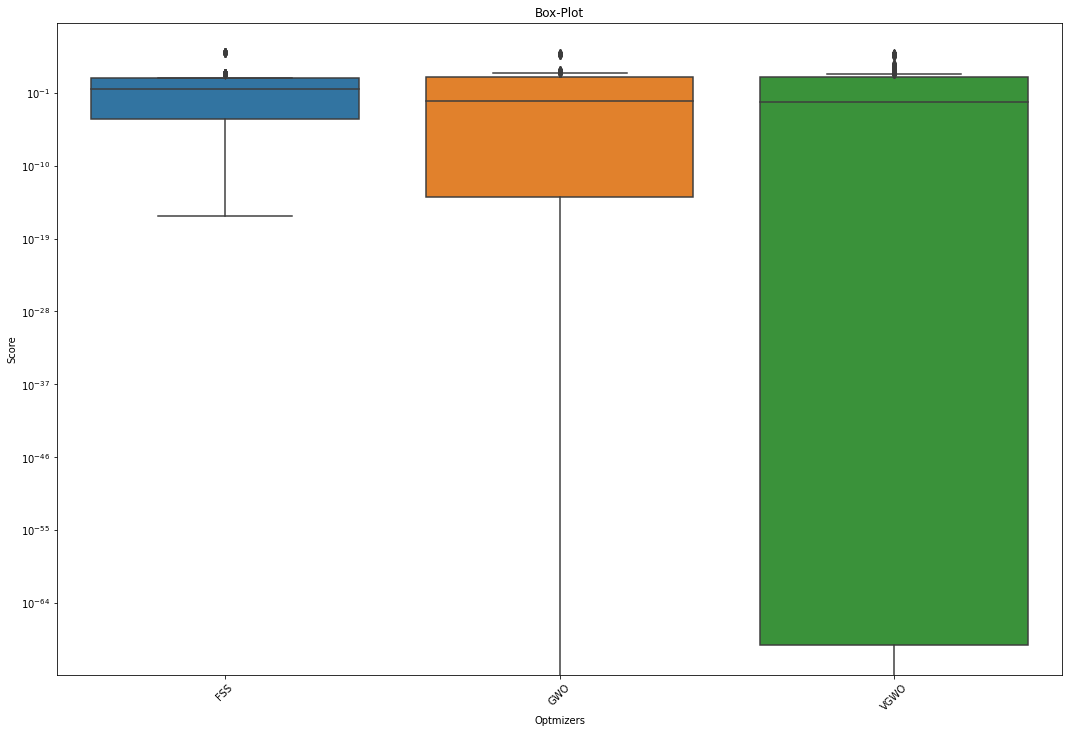

In [7]:
objective_functions = results[30]['func'].unique()
opts = results[30]['opt'].unique()
obj_show = []
for func in objective_functions:
  for o in opts[1:]:
    res = results[30][results[30]['func'] == func]
    res = res[res['opt'] == o].head(1)
    res = res.drop(['opt', 'func', 'exec_time'], axis=1)
    scores = res.values.tolist()[0]
    for s in scores:
      obj_show.append({'opt': o, 'score': s})
  
res = pd.DataFrame(data=obj_show, index=range(len(obj_show)), columns=['opt', 'score'])
# res = res[res["score"] <= 100] # remove outliers
# res = res[res["score"] >= -1000]
ax = sns.boxplot(data=res, x='opt', y='score')
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(xlabel= 'Optmizers', ylabel='Score', title='Box-Plot')

### Verification learning swarms in 10000 iterations

Now, for see the one execution, with 500 interation in the swarm to see the swarm evolution/learning me saved in differents files and show in graphics comparing every algoritms in the same iteration.

In [8]:
optimizers = ["PSO", "FSS", "GWO", "VGWO"]
files_30 = []
files_15 = []
filepath = os.path.dirname(os.path.abspath('Results'))
for opt in optimizers:
  filename = f"{filepath}/30d/{opt}_iter.csv"
  df = pd.read_csv(filename)
  files_30.append(df)
  filename = f"{filepath}/15d/{opt}_iter.csv"
  df = pd.read_csv(filename)
  files_15.append(df)

results_15 = pd.concat(files_15)
results_15.sort_values(by=['func'], ascending=False)
results_30 = pd.concat(files_30)
results_30.sort_values(by=['func'], ascending=False)
results = {15: results_15, 30: results_30}
results_30.head(5)

,opt,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run991,run992,run993,run994,run995,run996,run997,run998,run999,run1000
0,PSO,Sphere,2.575581,7.434347e+04,7.434347e+04,7.434347e+04,5.757809e+04,4.489207e+04,4.349002e+04,4.148861e+04,...,2.022205e+02,2.022205e+02,2.022205e+02,2.022205e+02,2.022205e+02,2.022205e+02,2.022205e+02,2.022205e+02,2.022205e+02,2.022205e+02
1,PSO,RotatedHyperEllipsoid,8.030217,3.675919e+05,3.520617e+05,3.520617e+05,2.595010e+05,2.541068e+05,2.506436e+05,2.436946e+05,...,2.109745e+02,2.109745e+02,2.109745e+02,2.109745e+02,2.109745e+02,2.109745e+02,2.109745e+02,2.109745e+02,2.109745e+02,2.109745e+02
2,PSO,Rosenbrock,2.847640,3.053519e+08,2.530857e+08,2.530857e+08,2.439319e+08,2.439319e+08,1.937516e+08,1.937516e+08,...,1.403489e+05,1.403489e+05,1.403489e+05,1.403489e+05,1.403489e+05,1.403489e+05,1.403489e+05,1.403489e+05,1.403489e+05,1.403489e+05
3,PSO,Dixon-Price,3.693327,6.732222e+06,6.551487e+06,6.518817e+06,6.512422e+06,6.511149e+06,6.510895e+06,5.611505e+06,...,2.121967e+01,2.121967e+01,2.121967e+01,2.121967e+01,2.121967e+01,2.121967e+01,2.121967e+01,2.121967e+01,2.121967e+01,2.121967e+01
4,PSO,Perm,42.515881,1.859292e+83,1.309135e+83,1.226115e+83,1.210427e+83,7.656774e+82,7.656774e+82,6.390672e+82,...,4.620600e+08,4.620332e+08,4.620079e+08,4.619966e+08,4.619928e+08,4.619841e+08,4.619785e+08,4.619760e+08,4.619754e+08,4.619740e+08


Functions w/ 15 dim


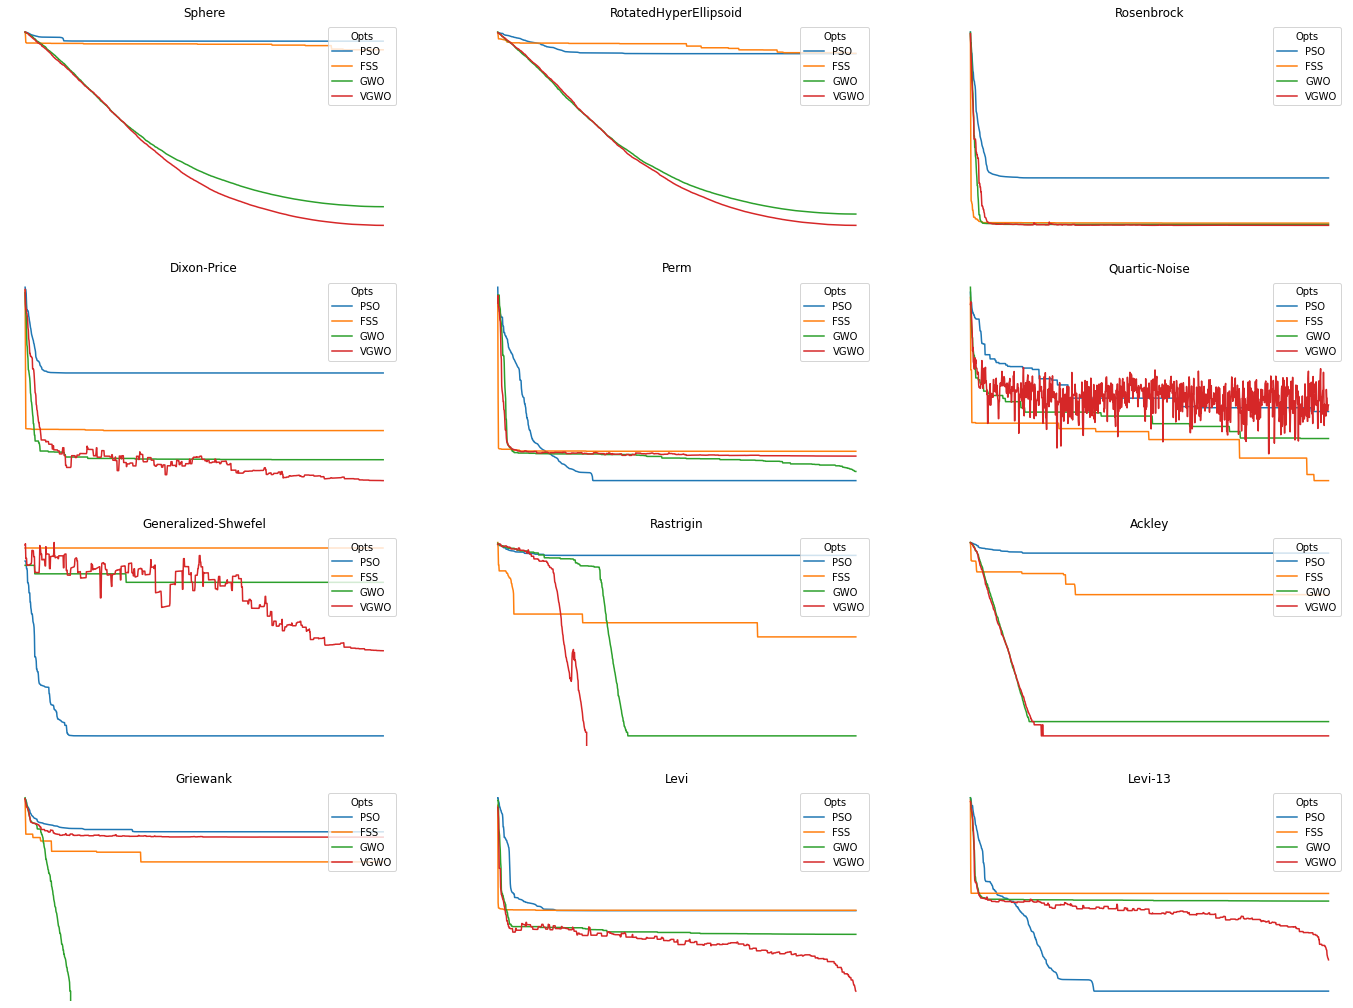

Functions w/ 30 dim


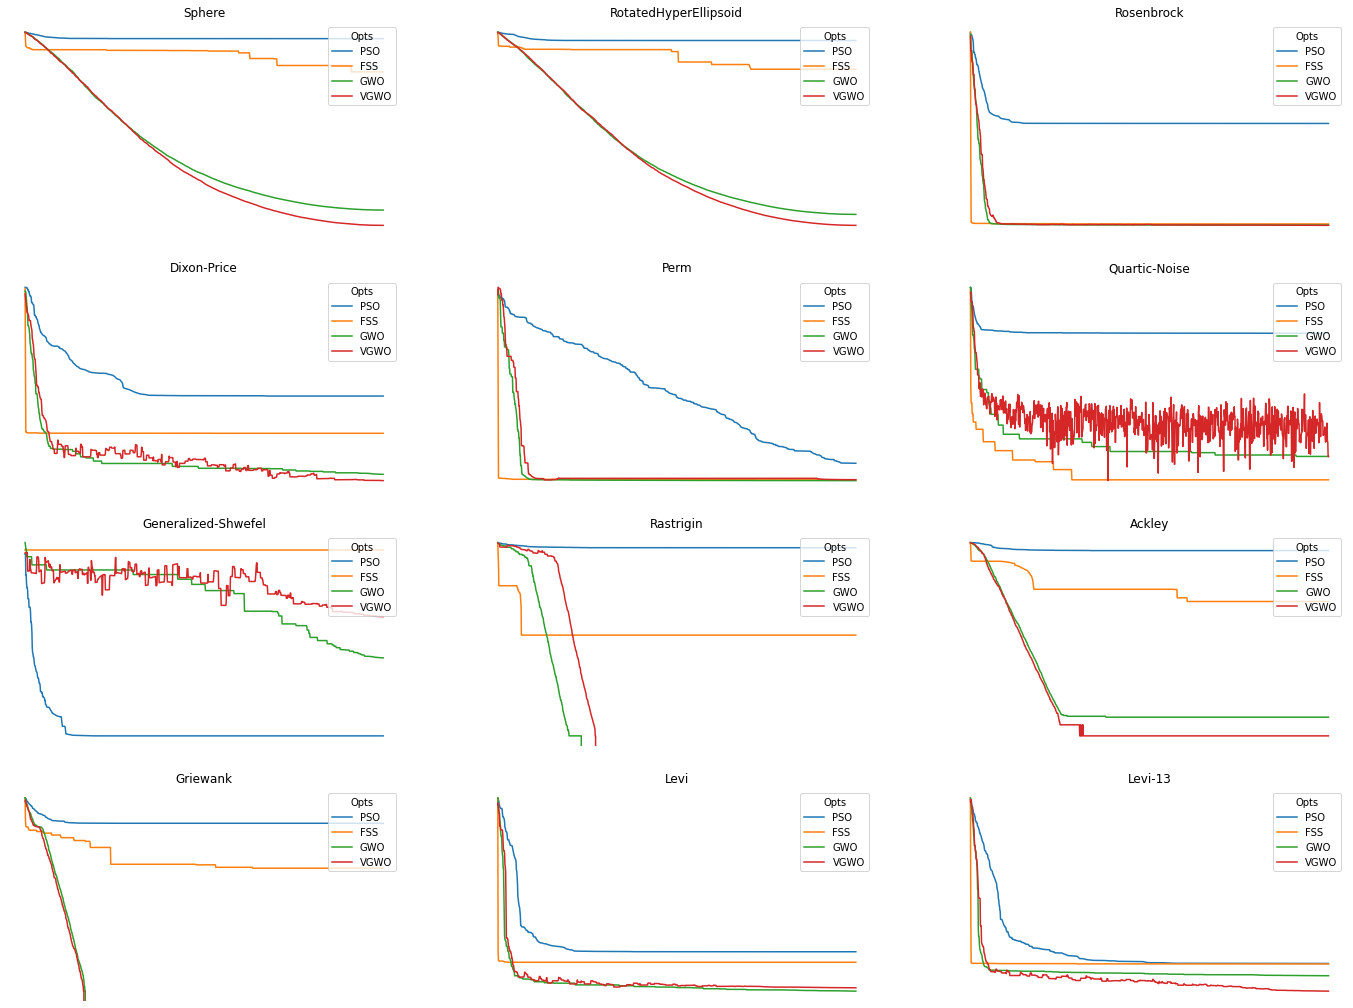

In [9]:
plt.rcParams["figure.figsize"] = (24,18)
for d in results:
  objective_functions = results[d]['func'].unique()
  opts = results[d]['opt'].unique()
  print(f"Functions w/ {d} dim")
  for i, func in enumerate(objective_functions):
    plt.subplot(4, 3, i+1)
    plt.axis('off')
    for o in opts:
      res = results[d][results[d]['func'] == func]
      res = res[res['opt'] == o].head(1)
      res = res.drop(['opt', 'func', 'exec_time'], axis=1)
      y = res.values.tolist()[0][:1000]
      dt = pd.DataFrame(data=y, index=range(1, len(y)+1), columns=['score'])
      plt.plot(dt, label=o)
      plt.yscale('log')
      plt.legend(loc='upper right', title="Opts")
    plt.title(func)
  plt.show()

### Verification steps volutives (15 dim)

Validate fitness curve in 300 interations

In [ ]:
steps = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4]
files = []
filepath = os.path.dirname(os.path.abspath('Results'))
for s in steps:
  filename = f"{filepath}/VGWO-vol/{s}-vol.csv"
  df = pd.read_csv(filename)
  files.append(df)

results = pd.concat(files)
results.sort_values(by=['func'], ascending=False)
results.head(5)

,step_vol,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run991,run992,run993,run994,run995,run996,run997,run998,run999,run1000
0,0.0001,Sphere,6.278477,1.509103e+04,1.125075e+04,6.123295e+03,3.052176e+03,3.051271e+03,1.738891e+03,9.870822e+02,...,4.217539e-112,4.201938e-112,4.187692e-112,4.176002e-112,4.163399e-112,4.154514e-112,4.148303e-112,4.143151e-112,4.140904e-112,4.139359e-112
1,0.0001,RotatedHyperEllipsoid,11.994315,3.488426e+04,2.468120e+04,2.294164e+04,1.315954e+04,1.033520e+04,7.456965e+03,3.566943e+03,...,2.176545e-117,2.163923e-117,2.159764e-117,2.151089e-117,2.146970e-117,2.143023e-117,2.140319e-117,2.139079e-117,2.137035e-117,2.135682e-117
2,0.0001,Rosenbrock,6.423344,1.563510e+07,5.989132e+06,5.699889e+06,3.112778e+06,1.420162e+06,1.418164e+06,1.001203e+06,...,1.126236e+01,1.126207e+01,1.126187e+01,1.126187e+01,1.126187e+01,1.126187e+01,1.126187e+01,1.126184e+01,1.126180e+01,1.126177e+01
3,0.0001,Dixon-Price,7.056172,4.192757e+05,1.168977e+05,9.658360e+04,5.029936e+04,3.252757e+04,1.679292e+04,6.309691e+03,...,1.141267e-03,1.140373e-03,1.140074e-03,1.138853e-03,1.135824e-03,1.134606e-03,1.132814e-03,1.131439e-03,1.130725e-03,1.130512e-03
4,0.0001,Perm,24.077730,2.852628e+27,1.977999e+27,5.798728e+24,5.768673e+24,1.734418e+22,4.735194e+20,1.108859e+19,...,5.856236e-04,4.436465e-04,4.436460e-04,4.436454e-04,4.436452e-04,4.204455e-04,3.422450e-04,3.069887e-04,2.794391e-04,2.687005e-04


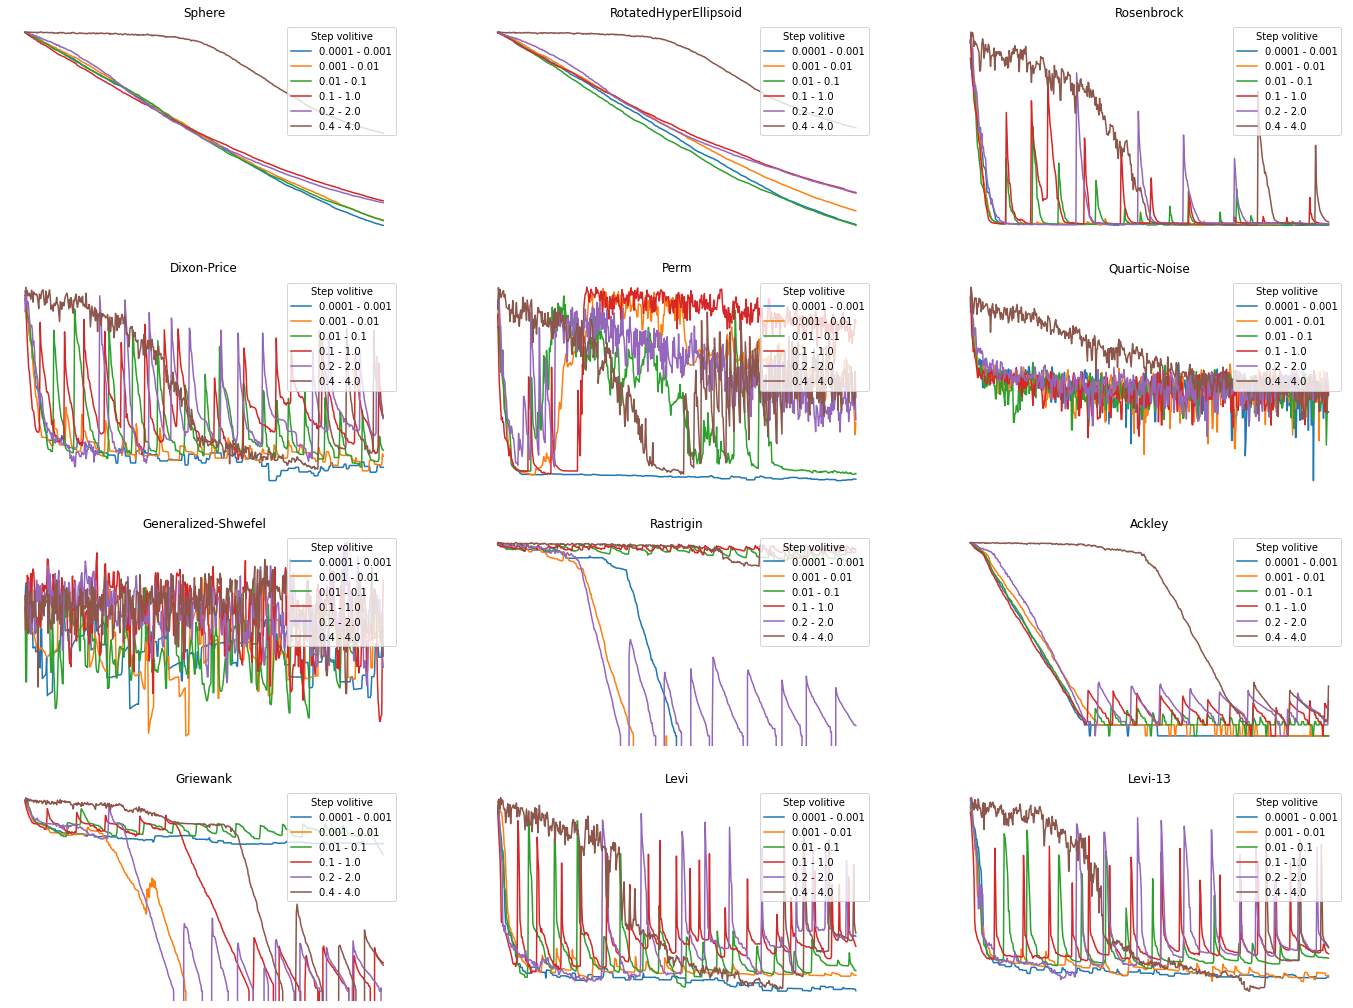

In [ ]:
plt.rcParams["figure.figsize"] = (24,18)
objective_functions = results['func'].unique()
steps = results['step_vol'].unique()
for i, func in enumerate(objective_functions):
  plt.subplot(4, 3, i+1)
  plt.axis('off')
  for s in steps:
    res = results[results['func'] == func]
    res = res[res['step_vol'] == s].head(1)
    res = res.drop(['step_vol', 'func', 'exec_time'], axis=1)
    y = res.values.tolist()[0][:500]
    dt = pd.DataFrame(data=y, index=range(1, len(y)+1), columns=['score'])
    plt.plot(dt, label=f"{s} - {s*10}")
    plt.legend(loc='upper right', title='Step volitive')
    plt.yscale('log')
  plt.title(func)
plt.show()

Validation fitness variance in 30 executions

In [ ]:
steps = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4]
files = []
filepath = os.path.dirname(os.path.abspath('Results'))
for s in steps:
  filename = f"{filepath}/VGWO-vol/VGWO_exec_{s}.csv"
  df = pd.read_csv(filename)
  files.append(df)

results = pd.concat(files)
results.sort_values(by=['func'], ascending=False)
results.head(5)

,step_vol,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run21,run22,run23,run24,run25,run26,run27,run28,run29,run30
0,0.0001,Sphere,183.075283,2.953736e-110,1.560956e-110,8.793494e-112,7.989284e-110,2.873316e-112,1.813784e-110,6.213114e-112,...,2.095413e-107,4.761173e-111,4.934290e-111,4.632698e-111,1.128050e-110,3.639504e-110,1.910449e-109,5.663042e-109,6.624650e-110,1.177638e-113
1,0.0001,RotatedHyperEllipsoid,356.493430,4.488008e-116,1.094382e-112,4.020697e-114,1.960151e-117,3.323796e-114,5.833924e-115,7.238146e-115,...,1.106998e-116,6.083285e-115,1.747310e-117,2.960482e-113,5.056102e-115,1.477408e-113,1.552887e-117,4.880523e-114,2.449435e-116,2.730444e-114
2,0.0001,Rosenbrock,194.060201,1.127030e+01,1.111341e+01,1.117517e+01,1.012839e+01,1.218149e+01,1.033207e+01,1.022527e+01,...,1.010222e+01,1.124917e+01,1.133177e+01,1.125834e+01,1.125345e+01,1.044037e+01,1.124161e+01,1.022738e+01,1.126622e+01,1.040055e+01
3,0.0001,Dixon-Price,202.581956,4.182781e-03,6.725961e-03,5.319469e-04,2.757590e-04,1.113707e-03,2.271861e-04,5.495878e-04,...,9.439003e-04,1.058551e-03,4.583363e-04,8.832870e-04,7.954616e-03,1.006471e-03,7.953487e-04,8.919384e-04,1.024717e-02,8.981225e-04
4,0.0001,Perm,726.114071,1.147980e+00,1.116629e+00,7.610498e-04,3.225389e-04,1.211040e-03,2.162606e+00,3.272408e+00,...,1.916494e+00,1.139532e+00,3.947651e+00,2.084510e+00,1.737121e-03,1.528695e+00,1.120527e+00,2.376328e+00,2.188169e+00,8.197861e-04


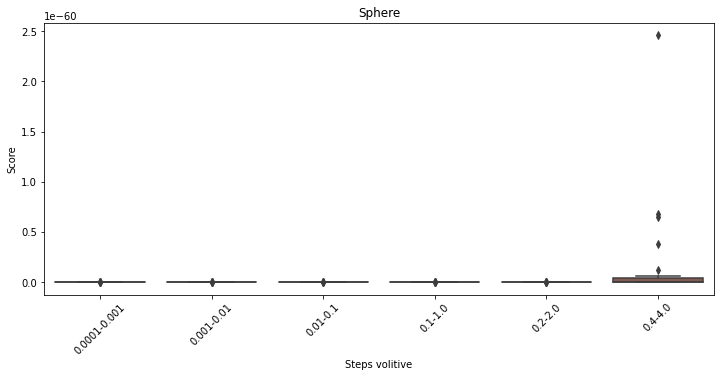

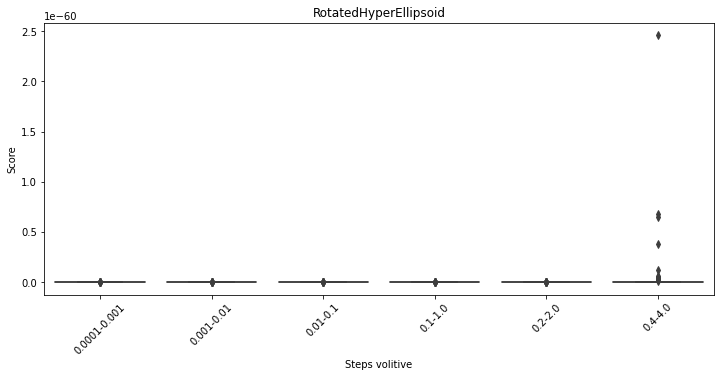

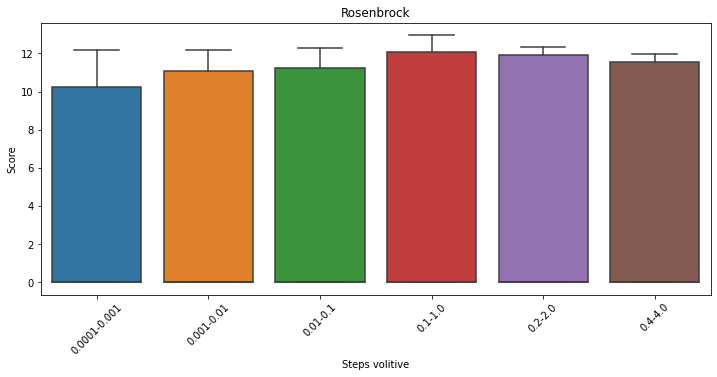

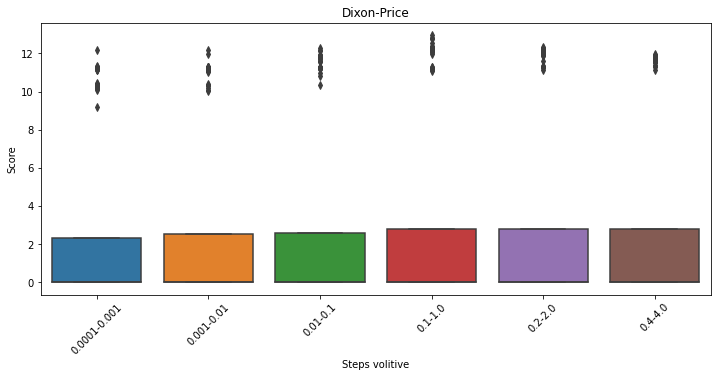

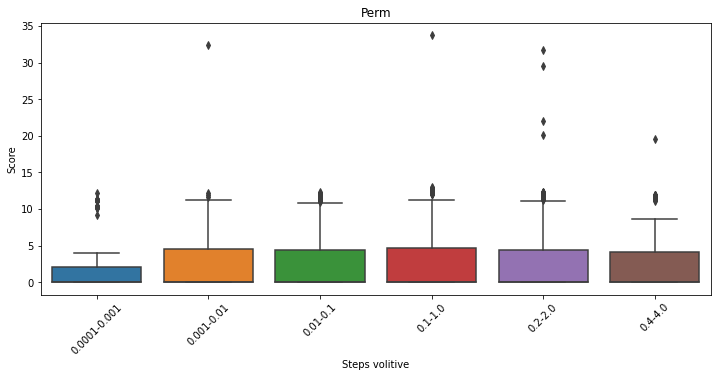

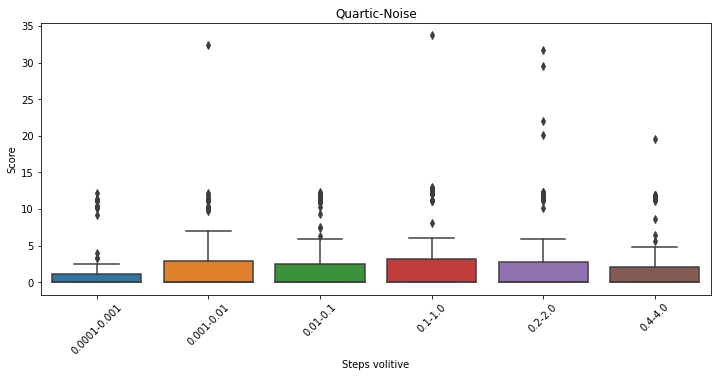

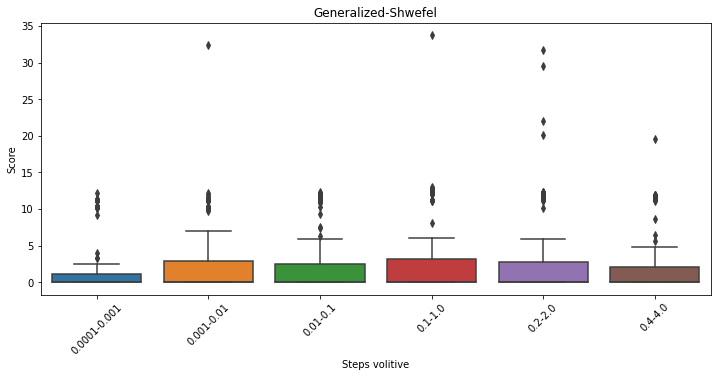

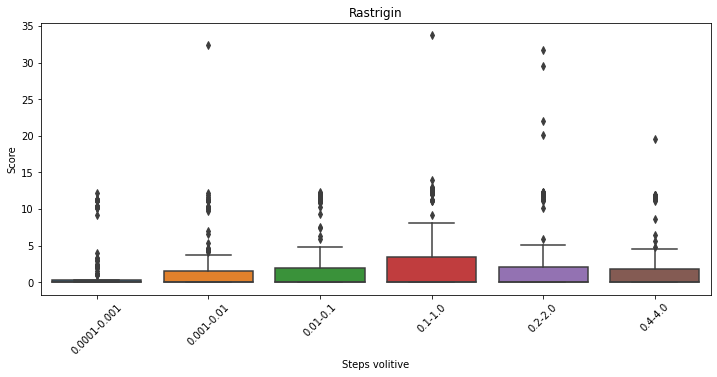

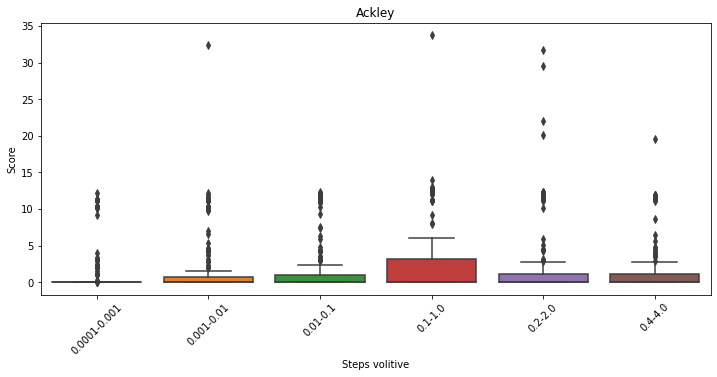

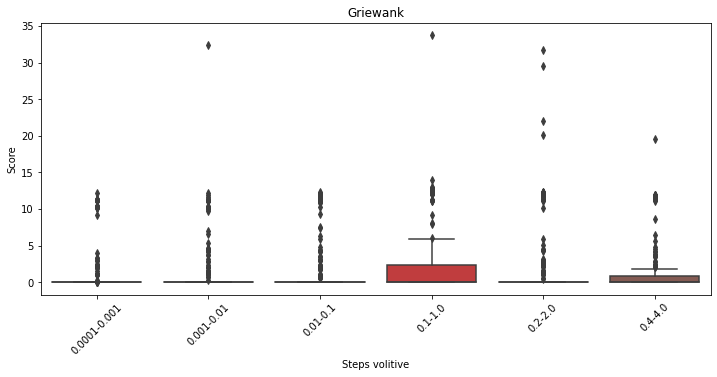

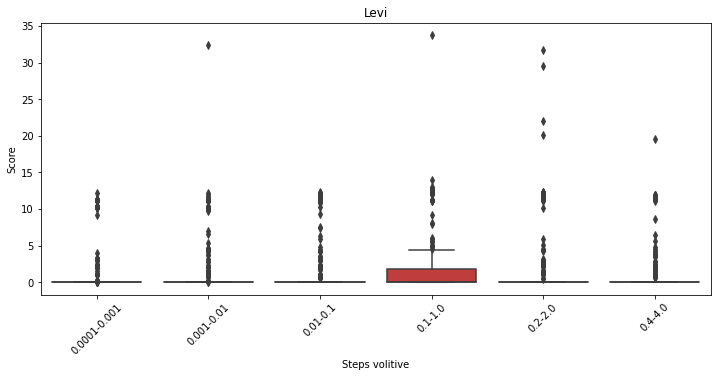

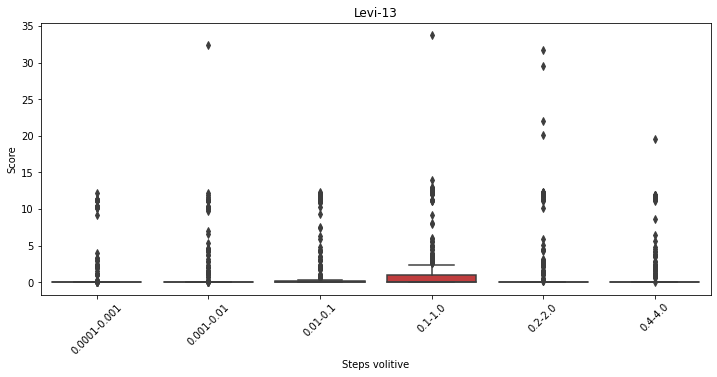

In [ ]:
plt.rcParams["figure.figsize"] = (12,5)
objective_functions = results['func'].unique()
steps_vol = results['step_vol'].unique()
obj_show = []
for func in objective_functions:
  for v in steps_vol:
    res = results[results['func'] == func]
    res = res[res['step_vol'] == v].head(1)
    res = res.drop(['step_vol', 'func', 'exec_time'], axis=1)
    scores = res.values.tolist()[0]
    for s in scores:
      obj_show.append({'step': f"{v}-{v*10}", 'score': s})
  
  res = pd.DataFrame(data=obj_show, index=range(len(obj_show)), columns=['step', 'score'])
  res = res[res["score"] <= 60] # remove outliers
  # res = res[res["score"] >= -1000]
  ax = sns.boxplot(data=res, x='step', y='score')
  # ax.set_yscale('log')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set(xlabel='Steps volitive', ylabel='Score', title=func)
  plt.show()